In [38]:
import tensorflow as tf
import keras
import keras_vggface
from keras_vggface.vggface import VGGFace
# Had to change code in keras vggface to make it work changed model.py line 20 as shown here https://stackoverflow.com/a/71379206
import numpy as np
import matplotlib as mpl
from keras.utils.data_utils import get_file
import keras_vggface.utils
import PIL
import os
import os.path
import matplotlib.pyplot as plt

In [14]:
train_seed = 42
split = 0.2

train_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=8, seed=train_seed, validation_split=split, subset='training')
val_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=8, seed=train_seed, validation_split=split, subset='validation')

Found 300 files belonging to 4 classes.
Using 240 files for training.
Found 300 files belonging to 4 classes.
Using 60 files for validation.


In [15]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2), ])

In [33]:
resnet_base = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [34]:
from keras.layers import Dense, Flatten, Input
from keras_vggface.vggface import VGGFace

num_classes = 4

resnet_base.trainable = False
last_layer = resnet_base.get_layer('avg_pool').output

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = resnet_base(x)
x = Flatten(name='flatten')(x)

out = Dense(num_classes, name='classifier')(x)

custom_resnet_model = keras.Model(inputs, out)

In [35]:
LR = 0.0001

custom_resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [36]:
base_history = custom_resnet_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20


2023-05-03 15:20:19.065306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 2.2021 - accuracy: 0.2708

2023-05-03 15:20:22.314624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 6s 242ms/step - loss: 2.2021 - accuracy: 0.2708 - val_loss: 1.4763 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 2s 158ms/step - loss: 1.2168 - accuracy: 0.5625 - val_loss: 0.7700 - val_accuracy: 0.7500
Epoch 3/20
15/15 [==============================] - 2s 153ms/step - loss: 0.8384 - accuracy: 0.7083 - val_loss: 0.5299 - val_accuracy: 0.8000
Epoch 4/20
15/15 [==============================] - 2s 154ms/step - loss: 0.6992 - accuracy: 0.7958 - val_loss: 0.3662 - val_accuracy: 0.9333
Epoch 5/20
15/15 [==============================] - 2s 156ms/step - loss: 0.6746 - accuracy: 0.7667 - val_loss: 0.3096 - val_accuracy: 0.9333
Epoch 6/20
15/15 [==============================] - 2s 152ms/step - loss: 0.5795 - accuracy: 0.8083 - val_loss: 0.2793 - val_accuracy: 0.9333
Epoch 7/20
15/15 [==============================] - 2s 152ms/step - loss: 0.6142 - accuracy: 0.7875 - val_loss: 0.2524 - val_accuracy: 0.9333
Epoch 8/20
15/15 

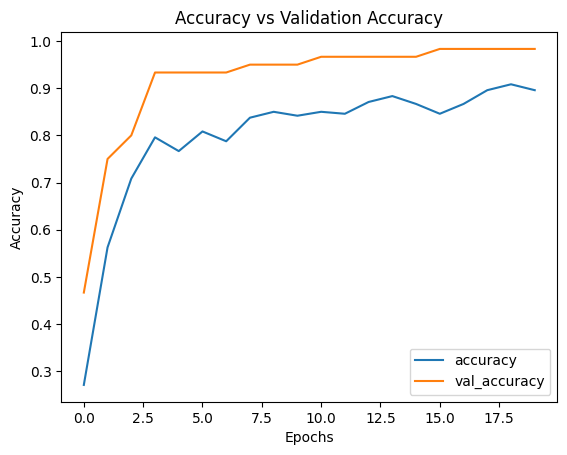

In [37]:
plt.plot(base_history.history['accuracy'], label='accuracy')
plt.plot(base_history.history['val_accuracy'], label='val_accuracy')

plt.title("Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Privacy

In [39]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
import tensorflow_privacy

In [40]:
train_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=16, seed=train_seed, validation_split=split, subset='training')
val_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=16, seed=train_seed, validation_split=split, subset='validation')

Found 300 files belonging to 4 classes.
Using 240 files for training.
Found 300 files belonging to 4 classes.
Using 60 files for validation.


In [49]:
from keras.layers import Dense, Flatten, Input
from keras_vggface.vggface import VGGFace

num_classes = 4

resnet_base.trainable = False
last_layer = resnet_base.get_layer('avg_pool').output

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = resnet_base(x)
x = Flatten(name='flatten')(x)

out = Dense(num_classes, name='classifier', activation='softmax')(x)

custom_resnet_model = keras.Model(inputs, out)

In [50]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)

In [51]:
noise_multiplier = 1.1
l2_norm_clip = 3
num_microbatches = 16
learning_rate = 0.0001

# optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     learning_rate=learning_rate
# )

optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

In [54]:
tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [55]:
LR = 0.0001

custom_resnet_model.compile(optimizer=optimizer,
    loss = loss,
    metrics=['accuracy'])

In [56]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = custom_resnet_model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/100


2023-05-04 10:55:44.951364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 4.3712 - accuracy: 0.1125

2023-05-04 10:55:49.221018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 8s 308ms/step - loss: 4.3712 - accuracy: 0.1125 - val_loss: 6.6368 - val_accuracy: 0.1500
Epoch 2/100
15/15 [==============================] - 3s 195ms/step - loss: 4.4935 - accuracy: 0.1042 - val_loss: 6.6010 - val_accuracy: 0.1333
Epoch 3/100
15/15 [==============================] - 3s 190ms/step - loss: 4.5897 - accuracy: 0.1208 - val_loss: 6.5102 - val_accuracy: 0.1333
Epoch 4/100
15/15 [==============================] - 3s 190ms/step - loss: 4.3960 - accuracy: 0.1125 - val_loss: 6.3856 - val_accuracy: 0.1333
Epoch 5/100
15/15 [==============================] - 3s 188ms/step - loss: 4.1756 - accuracy: 0.1458 - val_loss: 6.4035 - val_accuracy: 0.1333
Epoch 6/100
15/15 [==============================] - 3s 185ms/step - loss: 4.1246 - accuracy: 0.1667 - val_loss: 6.2891 - val_accuracy: 0.1500
Epoch 7/100
15/15 [==============================] - 3s 185ms/step - loss: 3.9717 - accuracy: 0.1875 - val_loss: 6.1645 - val_accuracy: 0.2000
Epoch 8/100

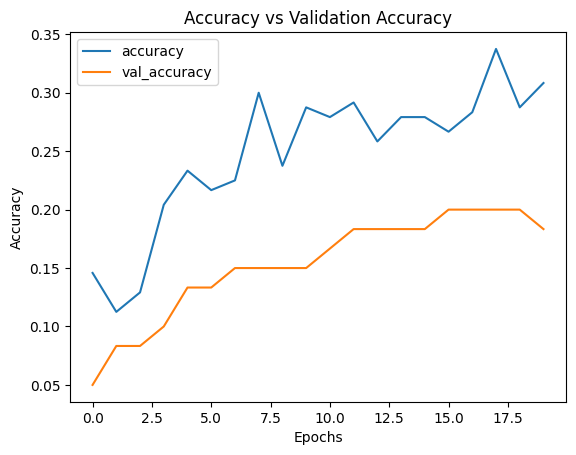

In [29]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.title("Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [57]:
tensorflow_privacy.compute_dp_sgd_privacy(240, 16, 1.1, 20, 1e-5)

DP-SGD with sampling rate = 6.67% and noise_multiplier = 1.1 iterated over 300 steps satisfies differential privacy with eps = 7.32 and delta = 1e-05.
The optimal RDP order is 3.5.


(7.3234449845072, 3.5)